In [134]:
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
from xgboost import XGBRegressor
from sklearn.metrics import make_scorer
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
import matplotlib.pyplot as plt

In [135]:
df = pd.read_csv(r"C:/Users/Olaf/Documents/studia/BigData/data/tesla_5m_20190201_20190522.csv",
                index_col='datetime', parse_dates=['datetime'])

In [136]:
df = df.rename({"marketVolume":"volume"},axis=1)

In [137]:
df = pd.concat([df['open'].resample(time).agg("first"),
    df['close'].resample(time).last(),
    df['high'].resample(time).max(),
    df['low'].resample(time).min(),
    df['volume'].resample(time).sum()], axis=1)

In [138]:
df = df.dropna().copy()

In [139]:
df = add_all_ta_features(df, "open", 'high','low', 'close', 'volume')

C:\Users\Olaf\AppData\Roaming\Python\Python36\site-packages\ta\trend.py:605: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_up = close.rolling(n).apply(lambda x: float(np.argmax(x) + 1) / n * 100)
C:\Users\Olaf\AppData\Roaming\Python\Python36\site-packages\ta\trend.py:627: FutureWarning: Currently, 'apply' passes the values as ndarrays to the applied function. In the future, this will change to passing it as Series objects. You need to specify 'raw=True' to keep the current behaviour, and you can pass 'raw=False' to silence this warning
  aroon_down = close.rolling(n).apply(lambda x: float(np.argmin(x) + 1) / n * 100)


In [140]:
df['profit'] = df['close'] - df['open']

In [141]:
df['lower_shadow'] = np.minimum(df['open'], df['close']) - df['low']
df['higher_shadow'] = df['high'] - np.maximum(df['open'], df['close'])

In [142]:
df['profit'] = df['profit'].shift(-1)

In [143]:
df = df.dropna(subset=['profit'])

In [144]:
df_test = df.loc['2019-05-15':]
df = df.loc[:'2019-05-21']

In [145]:
X = df.drop(['profit', 'others_dlr','others_dr', 'others_cr'],axis=1)
X_test = df_test.drop(['profit', 'others_dlr','others_dr', 'others_cr'],axis=1)

In [146]:
y = df['profit']
y_test = df_test['profit']

In [147]:
xgb = XGBRegressor()
cb = CatBoostRegressor(verbose=0, iterations=100)
rf = RandomForestRegressor(n_estimators=100, max_depth=3)
lr = LinearRegression()

In [148]:
def profit(y, y_pred):
    return y[y_pred>0].sum()

In [149]:
prof_scorer = make_scorer(profit)

In [150]:
cb.fit(X,y)

In [151]:
xgb.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [152]:
df_test['preds'] = xgb.predict(X_test)

In [153]:
df_test['profit_model'] = np.where(df_test['preds'] >0, df_test['profit'], -df_test['profit'])

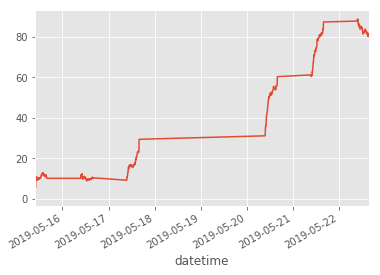

In [154]:
df_test['profit_model'].cumsum().plot()

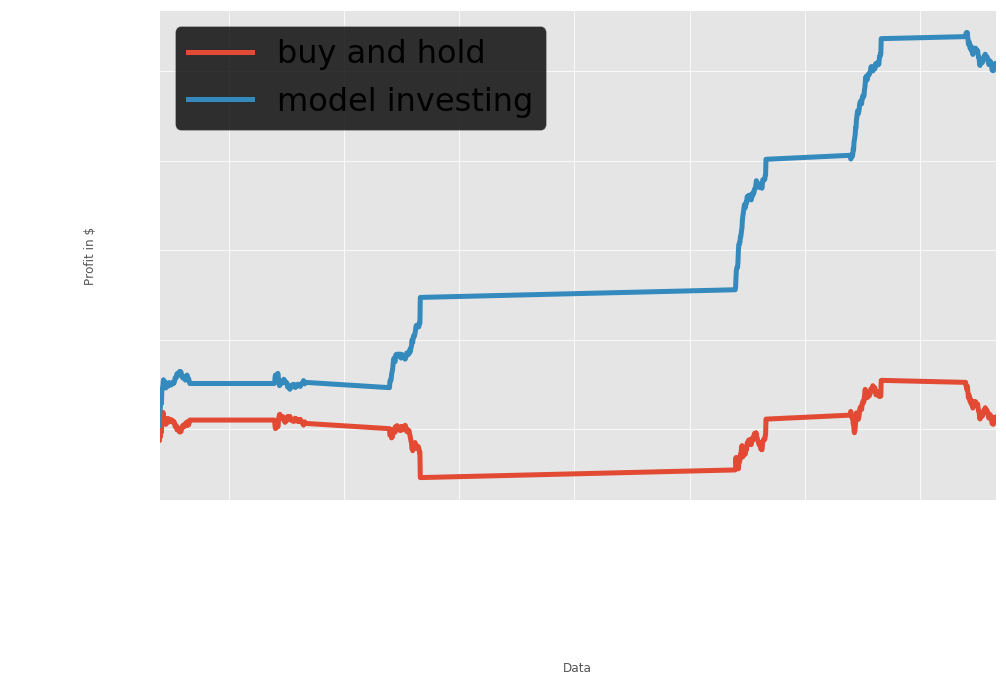

In [155]:
plt.figure(figsize=(15,10))
df_test['profit'].cumsum().plot(label="buy and hold", linewidth=5)
df_test['profit_model'].cumsum().plot(label="model investing", linewidth=5)
plt.legend()
plt.tick_params(colors='white', labelsize=40)
plt.legend(fontsize=32, facecolor="black")
#plt.xaxis.label.set_color('white')
plt.xlabel("Data")
plt.ylabel("Profit in $")
plt.savefig('profit_curve.png', transparent=True, pad_inches=2, bbox_inches = 'tight', dpi=300)

In [132]:
y_test[y_test < 0].sum()

-99.09500000000008

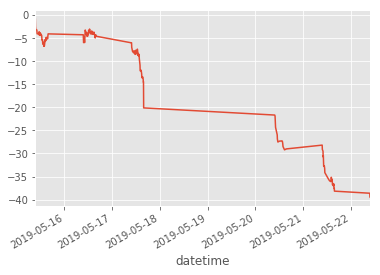

In [118]:
y_test[xgb.predict(X_test) < 0].cumsum().plot()

In [119]:
y_test.mean()

0.0039116379310343554

In [120]:
from sklearn.externals import joblib

In [128]:
set(['open', 'high', 'low', 'close', 'volume', 'volume_adi', 'volume_obv',
       'volume_obvm', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbm', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dch', 'volatility_dcl',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_adx_ind',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
       'trend_aroon_ind', 'momentum_rsi', 'momentum_mfi', 'momentum_tsi',
       'momentum_uo', 'momentum_stoch', 'momentum_stoch_signal', 'momentum_wr',
       'momentum_ao', 'lower_shadow', 'higher_shadow']).difference((set(X_test.columns)))


set()

In [122]:
X_test.columns

Index(['open', 'close', 'high', 'low', 'volume', 'volume_adi', 'volume_obv',
       'volume_obvm', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_vpt',
       'volume_nvi', 'volatility_atr', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbm', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kchi',
       'volatility_kcli', 'volatility_dch', 'volatility_dcl',
       'volatility_dchi', 'volatility_dcli', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow', 'trend_adx',
       'trend_adx_pos', 'trend_adx_neg', 'trend_adx_ind',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_diff',
       'trend_trix', 'trend_mass_index', 'trend_cci', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_a',
       'trend_ichimoku_b', 'trend_aroon_up', 'trend_aroon_down',
       'trend_aroon_ind', 'momentum_rsi', 'momentum_mfi', 'momentum_tsi

In [121]:
joblib.dump(xgb, "models/xgboost_price.h5")

['models/xgboost_price.h5']

In [129]:
xgb.predict(X_test)

array([-3.35015595e-01, -1.26677692e-01,  2.63250709e-01, -2.44122148e-02,
        1.05799466e-01,  1.27654284e-01,  2.17053294e-02,  8.46030414e-02,
        1.45485997e-02, -1.10998929e-01,  1.79609656e-02, -6.08147383e-02,
        8.84199142e-03,  1.43284500e-02,  5.58381975e-02,  3.78601849e-02,
        1.95005834e-02,  3.32144201e-02,  6.61790669e-02,  9.84347761e-02,
        9.30334628e-02, -4.71019745e-03, -4.71019745e-03, -4.71019745e-03,
       -4.71019745e-03, -4.71019745e-03, -4.71019745e-03, -4.71019745e-03,
       -8.34274292e-03, -8.34274292e-03, -8.34274292e-03, -4.71019745e-03,
       -1.45437717e-02, -1.09112263e-02, -1.09112263e-02, -1.09112263e-02,
       -2.13334560e-02, -2.13334560e-02, -2.13334560e-02, -2.13334560e-02,
       -2.13334560e-02,  1.41113102e-02, -1.85448527e-02, -3.43635082e-02,
       -2.21773982e-02, -2.20029354e-02, -1.15807056e-02, -1.15807056e-02,
       -8.12262297e-03, -1.15807056e-02, -1.34209394e-02, -1.92159414e-03,
       -1.82815194e-02, -

In [83]:
y_test[cb.predict(X_test) > 0].mean()

0.11442965779467702

In [156]:
import shap

In [157]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(X)

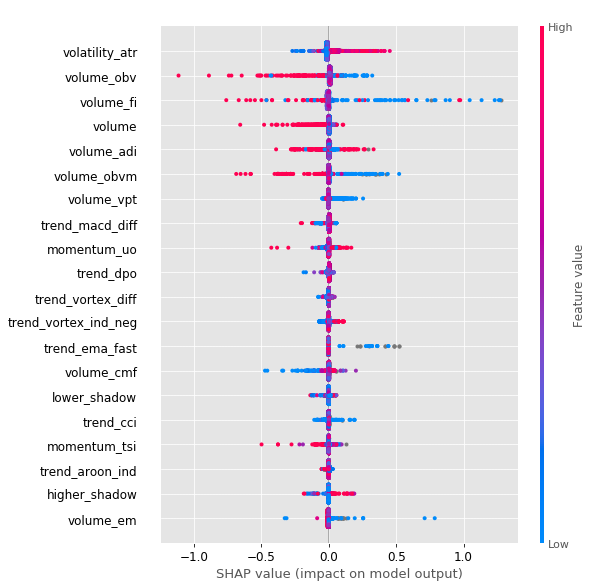

In [158]:
shap.summary_plot(shap_values, X, show=False)
plt.tick_params(colors='black', labelsize=12)
plt.savefig('var_imp.png', transparent=False, pad_inches=2, bbox_inches = 'tight', dpi=300)